In [95]:
import os
import re
import sys
import json
import datetime
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from datetime import datetime
import matplotlib.dates as mdates

%matplotlib inline

In [96]:
# Shared var
dirPath = './Data/StationCount'
weekdayMappingDic = {
    0: "Mon",
    1: "Tue",
    2: "Wed",
    3: "Thu",
    4: "Fri",
    5: "Sat",
    6: "Sun",
}
workday = ["Mon", "Tue", "Wed", "Thu", "Fri"]
weekend = ["Sat", "Sun"]


In [97]:
# For plot
majorColor = '#66BC5D'
sns.set(style='white', font='SimHei', font_scale=1.5)


In [98]:
# merge each monthly data file 
files = os.listdir(dirPath)
df = pd.DataFrame()
for fileName in sorted(files):
    print("[ fileName ]", fileName)
    monthlyDf = pd.read_excel(f"{dirPath}/{fileName}", engine="odf")
    df = df.append(monthlyDf, ignore_index=True)

[ fileName ] 202103.ods
[ fileName ] 202104.ods
[ fileName ] 202105.ods
[ fileName ] 202106.ods
[ fileName ] 202107.ods
[ fileName ] 202108.ods


In [99]:
df.head()

,Date,松山機場,中山國中,南京復興,忠孝復興,大安,科技大樓,六張犁,麟光,辛亥,...,秀朗橋,景平,中和,橋和,中原,板新,Y板橋,新埔民生,幸福,新北產業園區
0,2021-03-01,2904,7538,18272,34382,12499,7964,7036,3690,2131,...,2329,2788,3921,1129,1136,1680,6715,1796,3275,2737
1,2021-03-02,4008,15083,44233,39111,27086,15875,12242,4141,3274,...,2552,4151,4861,2243,3447,3064,7419,2400,3828,4319
2,2021-03-03,3880,15196,44666,40622,26717,15198,12066,3917,3222,...,2519,3975,4660,2272,3446,2933,7300,2474,3892,4148
3,2021-03-04,3901,15151,44594,40891,26884,15133,12194,4039,3336,...,2520,3995,4819,2292,3431,2965,7406,2455,3852,4162
4,2021-03-05,4242,15672,48271,47027,28495,15885,12638,4098,3391,...,2693,3988,5055,2327,3574,3035,9263,2640,4253,4548


In [100]:
stationCountDf = df.melt(id_vars=["Date"], var_name="station", value_name="count")
stationCountDf['weekday'] = list(map(lambda x: weekdayMappingDic[x.weekday()], stationCountDf['Date']))
stationCountDf['month'] = pd.DatetimeIndex(stationCountDf['Date']).month

In [101]:
stationCountDf.head()

,Date,station,count,weekday,month
0,2021-03-01,松山機場,2904,Mon,3
1,2021-03-02,松山機場,4008,Tue,3
2,2021-03-03,松山機場,3880,Wed,3
3,2021-03-04,松山機場,3901,Thu,3
4,2021-03-05,松山機場,4242,Fri,3


In [102]:
workdayStationCountDf = stationCountDf[stationCountDf['weekday'].isin(workday)]
weekendStationCountDf = stationCountDf[stationCountDf['weekday'].isin(weekend)]

# 平日、假日 各捷運站平均每日進出人數

In [103]:
workdayMeanCountDf = workdayStationCountDf.groupby(['station'], as_index=False) \
    .agg({'count': 'mean'})\
    .sort_values('count', ascending=False) \
    .reset_index(drop=True).rename(columns={'count':'avgDailyCount'})


weekendMeanCountDf = weekendStationCountDf.groupby(['station'], as_index=False) \
    .agg({'count': 'mean'})\
    .sort_values('count', ascending=False) \
    .reset_index(drop=True).rename(columns={'count':'avgDailyCount'})

In [104]:
workdayMeanCountDf.iloc[:6]

,station,avgDailyCount
0,台北車站,72988.469697
1,市政府,38115.181818
2,西門,33825.719697
3,南京復興,27572.916667
4,忠孝復興,26011.181818
5,松江南京,25487.037879


# 每日進出人數 Top 5 捷運站

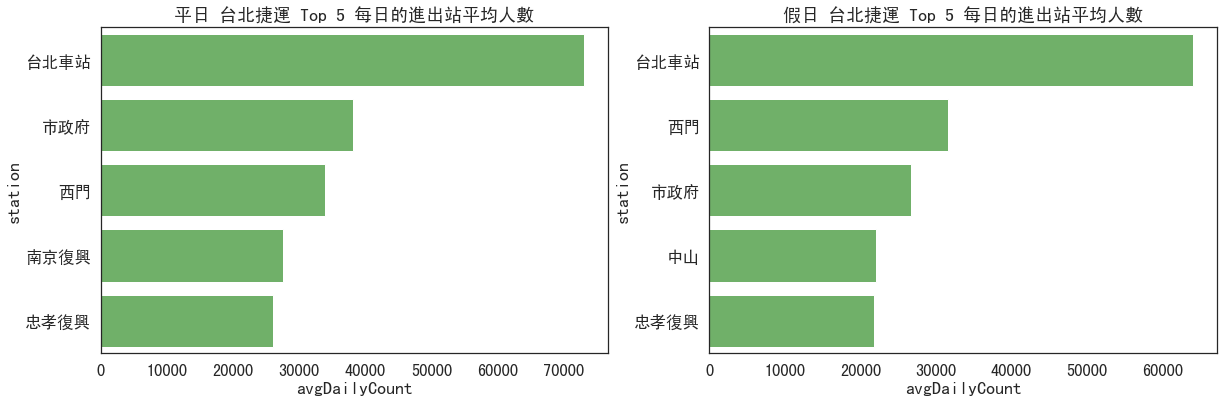

In [105]:
topN = 5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(y="station", x="avgDailyCount", data=workdayMeanCountDf.iloc[:topN], color=majorColor, ax= ax1).set_title('平日 台北捷運 Top 5 每日的進出站平均人數')
sns.barplot(y="station", x="avgDailyCount", data=weekendMeanCountDf.iloc[:topN], color=majorColor, ax= ax2).set_title('假日 台北捷運 Top 5 每日的進出站平均人數')
plt.savefig("./Result/meanStationCount.png", dpi=1200, facecolor=fig.get_facecolor())

# 每日進出人數 Bottom 5 捷運站

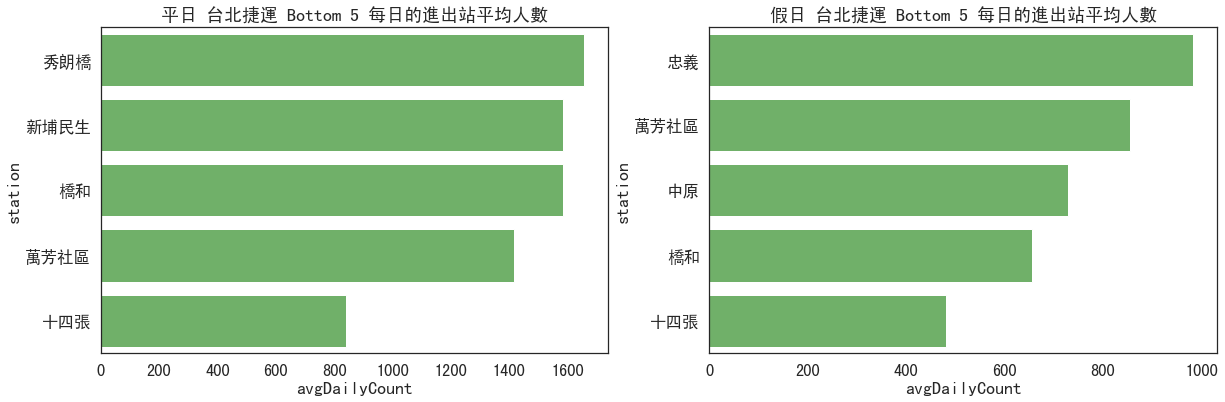

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(y="station", x="avgDailyCount", data=workdayMeanCountDf.iloc[-topN:], color=majorColor, ax= ax1).set_title('平日 台北捷運 Bottom 5 每日的進出站平均人數')
sns.barplot(y="station", x="avgDailyCount", data=weekendMeanCountDf.iloc[-topN:], color=majorColor, ax= ax2).set_title('假日 台北捷運 Bottom 5 每日的進出站平均人數')
plt.savefig("./Result/meanStationCount_bottom.png", dpi=1200, facecolor=fig.get_facecolor())

In [107]:
weeklyStationCountDf = stationCountDf.drop(['month', 'weekday'], axis=1).resample('W', on='Date').agg({'count': 'sum'})
weeklyStationCountDf = weeklyStationCountDf.reset_index().rename(columns={weeklyStationCountDf.index.name:'Date'})
weeklyStationCountDf.rename({'count': 'weeklyStationCount'}, inplace=True, axis=1)
weeklyStationCountDf = weeklyStationCountDf[:-1] # remove the last week ( less than a week )
weeklyStationCountDf.to_csv('./Result/weeklyStationCount.csv', encoding="utf-8-sig")

In [108]:
weeklyStationCountDf.head()

,Date,weeklyStationCount
0,2021-03-07,13593216
1,2021-03-14,14580956
2,2021-03-21,14417945
3,2021-03-28,14521851
4,2021-04-04,13379442


# 疫情對台北捷運總進出人數的影響  (2021.03 - 2021.08)

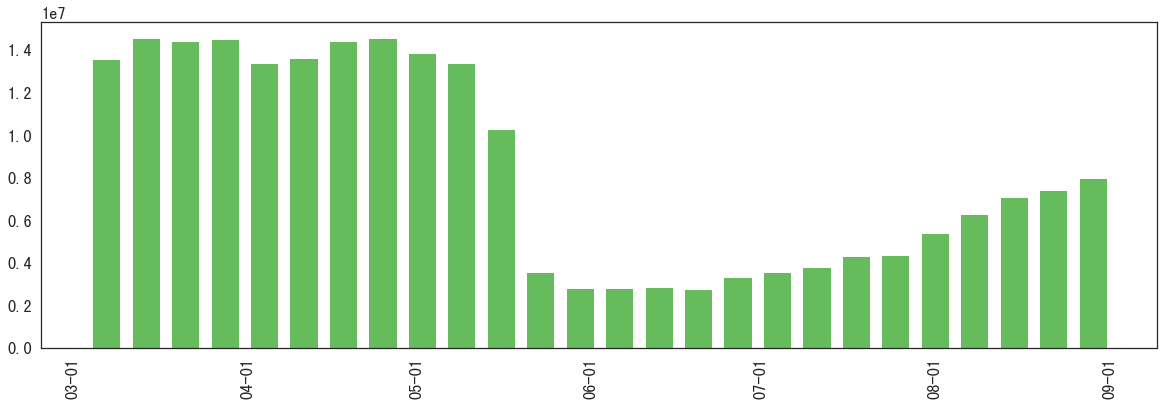

In [109]:
fig, ax1= plt.subplots(figsize=(20, 6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.bar(weeklyStationCountDf['Date'], weeklyStationCountDf['weeklyStationCount'], width=5, color=majorColor)
ax1.set(ylim=(0, max(weeklyStationCountDf['weeklyStationCount'])*1.05))
plt.xticks(rotation=90)
plt.savefig("./Result/weeklyTotalStationCount.png", dpi=1200, facecolor=fig.get_facecolor())

# 疫情後，捷運一週的進出人數最大下降到原先的 _ %

In [110]:
min(weeklyStationCountDf['weeklyStationCount'])*100/ max(weeklyStationCountDf['weeklyStationCount'])

18.89413486013543

# 比較疫情前後 各站人數差異大小

In [111]:
# get min, max week of station count value
minWeekIdx = weeklyStationCountDf['weeklyStationCount'].idxmin()
maxWeekIdx = weeklyStationCountDf['weeklyStationCount'].idxmax()

In [112]:
def coefficientVariation(x):
    return np.std(x, ddof=1) / np.mean(x) * 100

In [113]:
stationCountDf.head()

,Date,station,count,weekday,month
0,2021-03-01,松山機場,2904,Mon,3
1,2021-03-02,松山機場,4008,Tue,3
2,2021-03-03,松山機場,3880,Wed,3
3,2021-03-04,松山機場,3901,Thu,3
4,2021-03-05,松山機場,4242,Fri,3


In [114]:
stationCountCVDf = stationCountDf.groupby('station').agg({'count', coefficientVariation})
sortedCountCVStations = stationCountCVDf['count']['coefficientVariation'].sort_values(ascending=False)
sortedCountCVStations

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


station
動物園       98.103654
小南門       76.344557
西湖        76.078501
輔大        74.863535
南港軟體園區    72.717677
            ...    
台北橋       51.891356
竹圍        51.392796
中和        51.154784
三重國小      51.010825
復興崗       50.723919
Name: coefficientVariation, Length: 119, dtype: float64

# 差距最大、最小的捷運站

In [115]:
highestCountCVStation = sortedCountCVStations.keys()[0]
lowestCountCVStation = sortedCountCVStations.keys()[-1]
sumOfWeek = df.resample('W', on='Date').sum()
sumOfWeek.iloc[[maxWeekIdx, minWeekIdx]][[highestCountCVStation, lowestCountCVStation]]

,動物園,復興崗
Date,,
2021-04-25,42337,25955
2021-06-20,3258,7000
